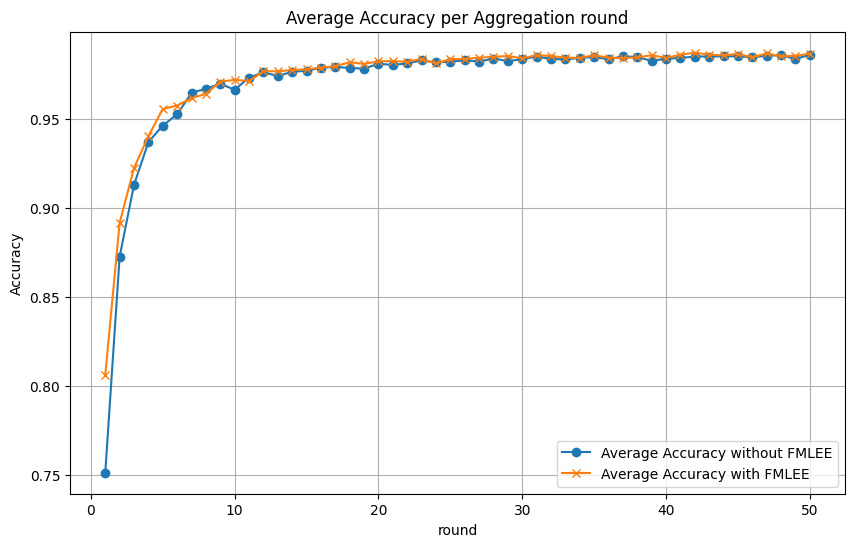

Array a: [[0.6776041388511658, 0.879479169845581, 0.9146875143051147, 0.9385416507720947, 0.9526041746139526, 0.9582291841506958, 0.9614583253860474, 0.9665625095367432, 0.9691666960716248, 0.9715625047683716, 0.9704166650772095, 0.9750000238418579, 0.9764583110809326, 0.9777083396911621, 0.9780208468437195, 0.9729166626930237, 0.9797916412353516, 0.9797916412353516, 0.9775000214576721, 0.9817708134651184, 0.9801041483879089, 0.9821875095367432, 0.9829166531562805, 0.9846875071525574, 0.981041669845581, 0.981041669845581, 0.9809374809265137, 0.981041669845581, 0.9743750095367432, 0.9820833206176758, 0.9858333468437195, 0.9860416650772095, 0.9816666841506958, 0.9821875095367432, 0.9848958253860474, 0.9751041531562805, 0.9860416650772095, 0.9822916388511658, 0.9831249713897705, 0.9825000166893005, 0.979895830154419, 0.9852083325386047, 0.9835416674613953, 0.9861458539962769, 0.9858333468437195, 0.9842708110809326, 0.9854166507720947, 0.9867708086967468, 0.984375, 0.9865624904632568], [0.

In [10]:
import numpy as np
import matplotlib.pyplot as plt


# Generate random accuracy values
def generate_random_accuracy(size):
    return np.random.uniform(0.7, 1.0, size)


# Generate arrays 'a' and 'b'


# Calculate the average accuracy per epoch
avg_a = np.mean(a, axis=0)
avg_b = np.mean(b, axis=0)

# Plotting the graph
epochs = np.arange(1, 51)
plt.figure(figsize=(10, 6))
plt.plot(epochs, avg_a, label="Average Accuracy without FMLEE", marker="o")
plt.plot(epochs, avg_b, label="Average Accuracy with FMLEE", marker="x")

plt.title("Average Accuracy per Aggregation round")
plt.xlabel("round")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Print arrays and averages for reference
print("Array a:", a)
print("Array b:", b)
print("Average Accuracy without FMLEE", avg_a)
print("Average Accuracy with FMLEE:", avg_b)

In [1]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)

# Check if GPU is available
gpus = tf.config.list_physical_devices("GPU")
if gpus:
    print("GPUs available:", len(gpus))
    for gpu in gpus:
        print(gpu)
else:
    print("No GPU available.")

2024-06-01 10:55:53.260283: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


AttributeError: partially initialized module 'charset_normalizer' has no attribute 'md__mypyc' (most likely due to a circular import)

In [1]:
import tensorflow as tf
from tqdm import tqdm
import copy
from cryptography.hazmat.primitives import hashes, serialization
from cryptography.hazmat.primitives.asymmetric import dh
from cryptography.hazmat.primitives.kdf.hkdf import HKDF
from cryptography.hazmat.primitives.ciphers import Cipher, algorithms, modes
import pickle
import sys


2024-05-30 18:16:12.531231: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-30 18:16:13.167258: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/cs-lab-12/.anaconda3/envs/ie39/lib/python3.9/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


In [2]:
clients = [i for i in range(5)]
epochs = 30

In [3]:
import tensorflow as tf
import numpy as np

# Load the MNIST dataset
(x_train_all, y_train_all), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Preprocess the data
x_train_all = x_train_all.astype(np.float32) / 255.0
x_test = x_test.astype(np.float32) / 255.0

In [4]:
# Define the model architecture
def create_model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Conv2D(
                32, (3, 3), activation="relu", input_shape=(28, 28, 1)
            ),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dense(10),
        ]
    )
    return model


# # Define the MAML model
# class MAML(tf.keras.Model):
#     def __init__(self, model):
#         super(MAML, self).__init__()
#         self.model = model

#     def train_step(self, data):
#         x, y = data
#         x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
#         y = tf.reshape(y, (-1,))  # Reshape the target labels
#         with tf.GradientTape() as tape:
#             y_pred = self.model(x)
#             loss = self.compiled_loss(y, y_pred)
#         gradients = tape.gradient(loss, self.model.trainable_variables)
#         self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
#         self.compiled_metrics.update_state(y, y_pred)
#         return {m.name: m.result() for m in self.metrics}

#     def test_step(self, data):
#         x, y = data
#         x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
#         y = tf.reshape(y, (-1,))  # Reshape the target labels
#         y_pred = self.model(x)
#         self.compiled_loss(y, y_pred)
#         self.compiled_metrics.update_state(y, y_pred)
#         return {m.name: m.result() for m in self.metrics}


class MAML(tf.keras.Model):
    def __init__(self, model):
        super(MAML, self).__init__()
        self.model = model

    def call(self, inputs):
        x = tf.reshape(inputs, (-1, 28, 28, 1))  # Reshape the input tensor
        return self.model(x)

    def get_config(self):
        return {"model": self.model.get_config()}

    @classmethod
    def from_config(cls, config):
        model = tf.keras.models.Model.from_config(config["model"])
        return cls(model)

    def train_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        with tf.GradientTape() as tape:
            y_pred = self.model(x)
            loss = self.compiled_loss(y, y_pred)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, data):
        x, y = data
        x = tf.reshape(x, (-1, 28, 28, 1))  # Reshape the input tensor
        y = tf.reshape(y, (-1,))  # Reshape the target labels
        y_pred = self.model(x)
        self.compiled_loss(y, y_pred)
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}


# Define the meta-learning parameters
num_meta_updates = 10
num_inner_updates = 5
meta_batch_size = 32
inner_batch_size = 10

In [5]:
from sklearn.model_selection import train_test_split

# assume X is your feature data and y is your target data
X_train, x_test, y_train, y_test = train_test_split(
    x_train_all, y_train_all, test_size=0.2, random_state=42
)

# split data into n parts
n_parts = len(clients)
part_size = len(X_train) // n_parts
dataset_parts = []
for i in range(n_parts):
    start = i * part_size
    end = (i + 1) * part_size
    X_part = X_train[start:end]
    y_part = y_train[start:end]
    dataset_parts.append((X_part, y_part))

In [6]:
a = dataset_parts
x , y = a[2]
len(x) , len(y)

(9600, 9600)

In [7]:
import os

os.environ["TF_USE_LEGACY_KERAS"] = "True"

In [8]:
def model_init():
    model = MAML(create_model())
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=["accuracy"],
    )
    return model


# %%
models = []
for _ in range(len(clients)):
    models.append(model_init())

/home/cs-lab-12/.anaconda3/envs/ie39/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1717073174.617444  439273 cuda_executor.cc:1020] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-30 18:16:14.661458: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required l

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
!which python


/home/cs-lab-12/.anaconda3/envs/ie39/bin/python


In [ ]:
import tensorflow as tf

print(tf.__version__)

2.17.0-dev20240529


In [ ]:
import numpy as np
from Pyfhel import Pyfhel

HE = Pyfhel() 
ckks_params = {
    "scheme": "CKKS", 
    "n": 2**14,  # Polynomial modulus degree. For CKKS, n/2 values can be
    "scale": 2**30,  # All the encodings will use it for float->fixed point
    "qi_sizes": [60, 30, 30, 30, 60],  # Number of bits of each prime in the chain.
}
HE.contextGen(**ckks_params)  # Generate context for ckks scheme
HE.keyGen()  # Key Generation: generates a pair of public/secret keys
HE.rotateKeyGen()
HE.relinKeyGen()

In [ ]:
shapedims = [l.shape for l in models[0].get_weights()]
print(shapedims)

[(3, 3, 1, 32), (32,), (3, 3, 32, 64), (64,), (3, 3, 64, 64), (64,), (576, 64), (64,), (64, 10), (10,)]


In [ ]:
def generate_diffie_hellman_parameters():
    parameters = dh.generate_parameters(generator=2, key_size=512)
    return parameters


def generate_diffie_hellman_keys(parameters):
    private_key = parameters.generate_private_key()
    public_key = private_key.public_key()
    return private_key, public_key


def derive_key(private_key, peer_public_key):
    shared_key = private_key.exchange(peer_public_key)
    derived_key = HKDF(
        algorithm=hashes.SHA256(),
        length=32,
        salt=None,
        info=b"handshake data",
    ).derive(shared_key)
    return derived_key


def encrypt_message_AES(key, message):
    serialized_obj = pickle.dumps(message)
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    encryptor = cipher.encryptor()
    padded_obj = serialized_obj + b" " * (16 - len(serialized_obj) % 16)
    ciphertext = encryptor.update(padded_obj) + encryptor.finalize()
    return ciphertext


def decrypt_message_AES(key, ciphertext):
    cipher = Cipher(algorithms.AES(key), modes.ECB())
    decryptor = cipher.decryptor()
    padded_obj = decryptor.update(ciphertext) + decryptor.finalize()
    serialized_obj = padded_obj.rstrip(b" ")
    obj = pickle.loads(serialized_obj)
    return obj


def setup_AES():
    num_clients = len(clients)
    parameters = generate_diffie_hellman_parameters()
    server_private_key, server_public_key = generate_diffie_hellman_keys(parameters)
    client_keys = [generate_diffie_hellman_keys(parameters) for _ in range(num_clients)]
    shared_keys = [
        derive_key(server_private_key, client_public_key)
        for _, client_public_key in client_keys
    ]
    client_shared_keys = [
        derive_key(client_private_key, server_public_key)
        for client_private_key, _ in client_keys
    ]

    return client_keys, shared_keys , client_shared_keys

In [ ]:
client_keys, shared_keys, client_shared_keys = setup_AES()

In [ ]:
def encrypt_wt(wtarray , i):
    cwt = []
    for layer in wtarray:
        flat_array = layer.astype(np.float64).flatten()

        chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
        clayer = []
        for chunk in chunks:
            ptxt = HE.encodeFrac(chunk)
            ctxt = HE.encryptPtxt(ptxt)
            clayer.append(ctxt)
        cwt.append(clayer.copy())
    ciphertext = encrypt_message_AES(client_shared_keys[i], cwt)
    return ciphertext

In [ ]:
def aggregate_wt(encypted_cwts):
    cwts = []
    for i , ecwt in enumerate(encypted_cwts):
        cwts.append(decrypt_message_AES(shared_keys[i], ecwt))
    resmodel = []
    for j in range(len(cwts[0])):  # for layers
        layer = []
        for k in range(len(cwts[0][j])):  # for chunks
            tmp = cwts[0][j][k].copy()
            for i in range(1, len(cwts)):  # for clients
                tmp = tmp + cwts[i][j][k]
            tmp = tmp / len(cwts)
            layer.append(tmp)
        resmodel.append(layer)

    res = [resmodel.copy() for _ in range(len(clients))]
    return res
    

In [ ]:
def decrypt_weights(res):
    decrypted_weights = []
    for client_weights, model in zip(res, models):
        decrypted_client_weights = []
        wtarray = model.get_weights()
        for layer_weights, layer in zip(client_weights, wtarray):
            decrypted_layer_weights = []
            flat_array = layer.astype(np.float64).flatten()
            chunks = np.array_split(flat_array, (len(flat_array) + 2**10 - 1) // 2**10)
            for chunk, encrypted_chunk in zip(chunks, layer_weights):
                decrypted_chunk = HE.decryptFrac(encrypted_chunk)
                original_chunk_size = len(chunk)
                decrypted_chunk = decrypted_chunk[:original_chunk_size]
                decrypted_layer_weights.append(decrypted_chunk)
            decrypted_layer_weights = np.concatenate(decrypted_layer_weights, axis=0)
            decrypted_layer_weights = decrypted_layer_weights.reshape(layer.shape)
            decrypted_client_weights.append(decrypted_layer_weights)
        decrypted_weights.append(decrypted_client_weights)
    return decrypted_weights

In [ ]:
accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

In [ ]:
# def train_model(model, x_train, y_train):
#     meta_updates = []
#     accuracy_over_time = []
#     for meta_update in range(num_meta_updates):
#         # Sample a meta-batch of tasks
#         meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

#         # Inner loop updates for each task
#         for task in meta_batch:
#             task_data = (
#                 x_train[task : task + inner_batch_size],
#                 y_train[task : task + inner_batch_size],
#             )
            
#             for inner_update in range(num_inner_updates):
#                 model.train_step(task_data)

#         # Evaluate on the meta-test set
#         _, accuracy = model.evaluate(x_test, y_test)

#         # Store the meta-update step and accuracy
#         meta_updates.append(meta_update + 1)
#         accuracy_over_time.append(accuracy)
#     avg_accuracy = sum(accuracy_over_time) / len(accuracy_over_time)
#     return model , avg_accuracy

In [ ]:
meta_batch_size = 32  # Number of tasks per meta-update
inner_batch_size = 5  # Number of examples per task
num_inner_updates = 1  # Number of inner loop updates per task
num_meta_updates = 1
optimizer = tf.keras.optimizers.legacy.Adam()

ImportError: `keras.optimizers.legacy` is not supported in Keras 3. When using `tf.keras`, to continue using a `tf.keras.optimizers.legacy` optimizer, you can install the `tf_keras` package (Keras 2) and set the environment variable `TF_USE_LEGACY_KERAS=True` to configure TensorFlow to use `tf_keras` when accessing `tf.keras`.

In [ ]:
def train_model(model, x_train, y_train):
    meta_updates = []
    accuracy_over_time = []
    for meta_update in range(num_meta_updates):
        # Sample a meta-batch of tasks
        meta_batch = tf.random.shuffle(tf.range(len(x_train)))[:meta_batch_size]

        # Inner loop updates for each task
        task_gradients = []
        for task in meta_batch:
            task_data = (
                x_train[task : task + inner_batch_size],
                y_train[task : task + inner_batch_size],
            )

            with tf.GradientTape() as outer_tape:
                with tf.GradientTape() as inner_tape:
                    # Forward pass on the task-specific data
                    predictions = model(task_data[0])
                    loss = tf.keras.losses.sparse_categorical_crossentropy(
                        task_data[1], predictions
                    )

                # Compute gradients for inner loop update
                inner_gradients = inner_tape.gradient(loss, model.trainable_variables)

                # Apply inner loop update to the model's variables
                inner_model = MAML(create_model())
                inner_model.set_weights(model.get_weights())
                optimizer.apply_gradients(
                    zip(inner_gradients, inner_model.trainable_variables)
                )

                # Forward pass with the updated model
                updated_predictions = inner_model(task_data[0])
                updated_loss = tf.keras.losses.sparse_categorical_crossentropy(
                    task_data[1], updated_predictions
                )

            # Compute gradients for outer loop update
            outer_gradients = outer_tape.gradient(
                updated_loss, model.trainable_variables
            )
            task_gradients.append(outer_gradients)

        # Filter out None gradients
        filtered_task_gradients = [
            [grad for grad in task_grad if grad is not None]
            for task_grad in task_gradients
        ]

        # Compute average gradients across tasks
        avg_gradients = [
            tf.reduce_mean(grad_list, axis=0)
            for grad_list in zip(*filtered_task_gradients)
        ]

        # Apply outer loop update to the model's variables
        optimizer.apply_gradients(zip(avg_gradients, model.trainable_variables))

        # Evaluate on the meta-test set
        _, accuracy = model.evaluate(x_test, y_test)

        # Store the meta-update step and accuracy
        meta_updates.append(meta_update + 1)
        accuracy_over_time.append(accuracy)

    avg_accuracy = sum(accuracy_over_time) / len(accuracy_over_time)
    return model, avg_accuracy

In [ ]:
def train_model(model, x_train, y_train):
    history = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=1,
        verbose=1,
        validation_data=(x_test, y_test),
    )
    avg_accuracy = history.history["val_accuracy"][-1]
    return model, avg_accuracy

In [ ]:
accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

In [ ]:



def agg_wts():
    # Get the weights of the first model
    avg_weights = models[0].get_weights()

    # Sum the weights of all models
    for model in models[1:]:
        model_weights = model.get_weights()
        for layer_index in range(len(avg_weights)):
            avg_weights[layer_index] += model_weights[layer_index]

    # Divide by the number of models to get the average
    for layer_index in range(len(avg_weights)):
        avg_weights[layer_index] = np.array(avg_weights[layer_index]) / len(models)

    return [avg_weights for _ in range(len(models))]




In [ ]:
def maml_train_step(model, x_train, y_train, inner_lr, num_inner_updates):
    with tf.GradientTape() as outer_tape:
        for i in range(num_inner_updates):
            with tf.GradientTape() as inner_tape:
                predictions = model(x_train, training=True)
                loss = tf.keras.losses.sparse_categorical_crossentropy(
                    y_train, predictions
                )
            grads = inner_tape.gradient(loss, model.trainable_variables)
            k = 0
            for j in range(len(grads)):
                if grads[j] is not None:
                    model.trainable_variables[k].assign_add(-inner_lr * grads[j])
                k += 1
        outer_loss = tf.keras.losses.sparse_categorical_crossentropy(
            y_train, model(x_train, training=True)
        )
    outer_grads = outer_tape.gradient(outer_loss, model.trainable_variables)
    return outer_loss, outer_grads

In [ ]:
from tqdm import tqdm

inner_lr = 0.01
num_inner_updates = 1
outer_lr = 0.001
epochs = 20

optimizer = tf.keras.optimizers.Adam(learning_rate=outer_lr)

accuracies = [[] for _ in range(len(clients))]
losses = [[] for _ in range(len(clients))]

for epoch in tqdm(range(epochs)):
    cwts = [encrypt_wt(model.get_weights(), i) for i, model in enumerate(models)]
    aggregated_cwts = aggregate_wt(cwts)
    decrypted_weights = decrypt_weights(aggregated_cwts)

    # Aggregate weights and set them for each model
    avg_weights = decrypted_weights[0]
    for layer in range(len(avg_weights)):
        for client in range(1, len(decrypted_weights)):
            avg_weights[layer] += decrypted_weights[client][layer]
        avg_weights[layer] = avg_weights[layer] / len(decrypted_weights)

    # Update each model with aggregated weights
    for model in models:
        model.set_weights(avg_weights)

    # Meta-training on each client
    for i, (model, dataset) in enumerate(zip(models, dataset_parts)):
        x_train, y_train = dataset
        for step in range(num_meta_updates):
            outer_loss, outer_grads = maml_train_step(
                model, x_train, y_train, inner_lr, num_inner_updates
            )
            optimizer.apply_gradients(zip(outer_grads, model.trainable_variables))

        # Evaluation and recording metrics
        history = model.fit(
            x_train,
            y_train,
            epochs=1,
            batch_size=64,
            verbose=1,
            validation_data=(x_test, y_test),
        )
        accuracies[i].append(history.history["val_accuracy"][-1])
        losses[i].append(history.history["val_loss"][-1])
        new_weights = model.get_weights()
        cwts[i] = encrypt_wt(new_weights, i)

  0%|                                                               | 0/20 [00:00<?, ?it/s]

150/150 [==============================] - 2s 15ms/step - loss: 1152648207247867904.0000 - accuracy: 0.0898 - val_loss: 1151985476614225920.0000 - val_accuracy: 0.0920


  5%|██▊                                                    | 1/20 [00:54<17:23, 54.94s/it]

150/150 [==============================] - 2s 14ms/step - loss: 34018644950253568.0000 - accuracy: 0.1037 - val_loss: 33893077286387712.0000 - val_accuracy: 0.1082


 10%|█████▌                                                 | 2/20 [01:47<15:59, 53.29s/it]

150/150 [==============================] - 2s 13ms/step - loss: 33215582702665728.0000 - accuracy: 0.1037 - val_loss: 33140369235378176.0000 - val_accuracy: 0.1082


 15%|████████▎                                              | 3/20 [02:40<15:03, 53.16s/it]

150/150 [==============================] - 2s 14ms/step - loss: 32511815803994112.0000 - accuracy: 0.1037 - val_loss: 32443459251994624.0000 - val_accuracy: 0.1082


 20%|███████████                                            | 4/20 [03:32<14:08, 53.02s/it]

150/150 [==============================] - 2s 14ms/step - loss: 31833064942338048.0000 - accuracy: 0.1037 - val_loss: 31766381280100352.0000 - val_accuracy: 0.1082


 25%|█████████████▊                                         | 5/20 [04:25<13:15, 53.05s/it]

150/150 [==============================] - 2s 14ms/step - loss: 31163458066055168.0000 - accuracy: 0.1037 - val_loss: 31094253258014720.0000 - val_accuracy: 0.1082


 30%|████████████████▌                                      | 6/20 [05:19<12:26, 53.36s/it]

150/150 [==============================] - 2s 14ms/step - loss: 30500141169377280.0000 - accuracy: 0.1037 - val_loss: 30429441712717824.0000 - val_accuracy: 0.1082


 35%|███████████████████▎                                   | 7/20 [06:12<11:32, 53.24s/it]

150/150 [==============================] - 2s 14ms/step - loss: 29886310885883904.0000 - accuracy: 0.1105 - val_loss: 29884627258703872.0000 - val_accuracy: 0.1159


 40%|██████████████████████                                 | 8/20 [07:05<10:37, 53.08s/it]

150/150 [==============================] - 2s 13ms/step - loss: 29381658671054848.0000 - accuracy: 0.1153 - val_loss: 29384929288650752.0000 - val_accuracy: 0.1142


 45%|████████████████████████▊                              | 9/20 [07:57<09:41, 52.84s/it]

150/150 [==============================] - 2s 14ms/step - loss: 28886124671795200.0000 - accuracy: 0.1145 - val_loss: 28885373052518400.0000 - val_accuracy: 0.1138


 50%|███████████████████████████                           | 10/20 [08:50<08:48, 52.85s/it]

150/150 [==============================] - 2s 14ms/step - loss: 28394464733036544.0000 - accuracy: 0.1128 - val_loss: 28390264255021056.0000 - val_accuracy: 0.1133


 55%|█████████████████████████████▋                        | 11/20 [09:44<07:56, 52.95s/it]

150/150 [==============================] - 2s 14ms/step - loss: 27903292273065984.0000 - accuracy: 0.1118 - val_loss: 27894410280697856.0000 - val_accuracy: 0.1129


 60%|████████████████████████████████▍                     | 12/20 [10:37<07:03, 52.99s/it]

150/150 [==============================] - 2s 14ms/step - loss: 27414288771579904.0000 - accuracy: 0.1118 - val_loss: 27400727412342784.0000 - val_accuracy: 0.1128


 65%|███████████████████████████████████                   | 13/20 [11:30<06:11, 53.03s/it]

150/150 [==============================] - 2s 14ms/step - loss: 26925819993522176.0000 - accuracy: 0.1116 - val_loss: 26908844135284736.0000 - val_accuracy: 0.1116


 70%|█████████████████████████████████████▊                | 14/20 [12:23<05:18, 53.05s/it]

150/150 [==============================] - 2s 14ms/step - loss: 26436329013248000.0000 - accuracy: 0.1122 - val_loss: 26415098989903872.0000 - val_accuracy: 0.1121


 75%|████████████████████████████████████████▌             | 15/20 [13:15<04:24, 52.93s/it]

150/150 [==============================] - 2s 13ms/step - loss: 25947954724470784.0000 - accuracy: 0.1134 - val_loss: 25921643754815488.0000 - val_accuracy: 0.1119


 80%|███████████████████████████████████████████▏          | 16/20 [14:08<03:31, 52.95s/it]

150/150 [==============================] - 2s 14ms/step - loss: 25460523181015040.0000 - accuracy: 0.1128 - val_loss: 25431368943009792.0000 - val_accuracy: 0.1118


 85%|█████████████████████████████████████████████▉        | 17/20 [15:02<02:38, 52.99s/it]

150/150 [==============================] - 2s 14ms/step - loss: 24972127417401344.0000 - accuracy: 0.1127 - val_loss: 24937933035274240.0000 - val_accuracy: 0.1123


 90%|████████████████████████████████████████████████▌     | 18/20 [15:55<01:46, 53.01s/it]

150/150 [==============================] - 2s 14ms/step - loss: 24485419575934976.0000 - accuracy: 0.1136 - val_loss: 24447677550821376.0000 - val_accuracy: 0.1121


 95%|███████████████████████████████████████████████████▎  | 19/20 [16:48<00:53, 53.13s/it]

150/150 [==============================] - 2s 14ms/step - loss: 23998683817181184.0000 - accuracy: 0.1135 - val_loss: 23956500795883520.0000 - val_accuracy: 0.1138


100%|██████████████████████████████████████████████████████| 20/20 [17:41<00:00, 53.09s/it]


In [ ]:
for e in tqdm(range(epochs)):
	cwts = [encrypt_wt(model.get_weights(), i) for i, model in enumerate(models)]
	aggregated_cwts = aggregate_wt(cwts)
	decrypted_weights = decrypt_weights(aggregated_cwts)

	# setup_AES()
	wts = [model.get_weights() for model in models]
	decrypted_weights = agg_wts() 
	for i, (wt, model, dataset) in enumerate(
		zip(decrypted_weights, models, dataset_parts)
	):
		model.set_weights(wt)
		history = model.fit(
			dataset[0],
			dataset[1],
			epochs=1,
			batch_size=64,
			verbose=1,
			validation_data=(x_test, y_test),
		)
		accuracies[i].append(history.history["val_accuracy"][-1])
		losses[i].append(history.history["val_loss"][-1])
		new_weights = model.get_weights()
		cwts[i] = encrypt_wt(new_weights, i)

  0%|                                                               | 0/20 [00:00<?, ?it/s]

150/150 [==============================] - 2s 13ms/step - loss: 23513668192829440.0000 - accuracy: 0.1141 - val_loss: 23467256776228864.0000 - val_accuracy: 0.1127


  5%|██▊                                                    | 1/20 [00:24<07:48, 24.67s/it]

150/150 [==============================] - 2s 14ms/step - loss: 23029279633702912.0000 - accuracy: 0.1138 - val_loss: 22979526732546048.0000 - val_accuracy: 0.1142


 10%|█████▌                                                 | 2/20 [00:47<07:00, 23.33s/it]

150/150 [==============================] - 2s 14ms/step - loss: 22545829524930560.0000 - accuracy: 0.1144 - val_loss: 22491723674419200.0000 - val_accuracy: 0.1142


 15%|████████▎                                              | 3/20 [01:10<06:34, 23.21s/it]

150/150 [==============================] - 2s 13ms/step - loss: 22063839705038848.0000 - accuracy: 0.1144 - val_loss: 22007919230844928.0000 - val_accuracy: 0.1157


 20%|███████████                                            | 4/20 [01:32<06:05, 22.84s/it]

150/150 [==============================] - 2s 13ms/step - loss: 21582638011645952.0000 - accuracy: 0.1148 - val_loss: 21522613696200704.0000 - val_accuracy: 0.1163


 25%|█████████████▊                                         | 5/20 [01:54<05:39, 22.60s/it]

150/150 [==============================] - 2s 13ms/step - loss: 21104170064936960.0000 - accuracy: 0.1163 - val_loss: 21041244499083264.0000 - val_accuracy: 0.1171


 30%|████████████████▌                                      | 6/20 [02:16<05:13, 22.42s/it]

150/150 [==============================] - 2s 14ms/step - loss: 20627149522206720.0000 - accuracy: 0.1173 - val_loss: 20561631943589888.0000 - val_accuracy: 0.1191


 35%|███████████████████▎                                   | 7/20 [02:38<04:51, 22.39s/it]

150/150 [==============================] - 2s 13ms/step - loss: 20151432502050816.0000 - accuracy: 0.1176 - val_loss: 20083256338677760.0000 - val_accuracy: 0.1202


 40%|██████████████████████                                 | 8/20 [03:01<04:30, 22.50s/it]

150/150 [==============================] - 2s 14ms/step - loss: 19678623174754304.0000 - accuracy: 0.1192 - val_loss: 19605930853269504.0000 - val_accuracy: 0.1208


 45%|████████████████████████▊                              | 9/20 [03:24<04:07, 22.46s/it]

150/150 [==============================] - 2s 14ms/step - loss: 19209052252798976.0000 - accuracy: 0.1195 - val_loss: 19135088620994560.0000 - val_accuracy: 0.1208


 50%|███████████████████████████                           | 10/20 [03:46<03:45, 22.59s/it]

150/150 [==============================] - 2s 14ms/step - loss: 18739906532605952.0000 - accuracy: 0.1208 - val_loss: 18664151899439104.0000 - val_accuracy: 0.1225


 55%|█████████████████████████████▋                        | 11/20 [04:10<03:24, 22.75s/it]

150/150 [==============================] - 2s 14ms/step - loss: 18273745814683648.0000 - accuracy: 0.1204 - val_loss: 18195034096533504.0000 - val_accuracy: 0.1229


 60%|████████████████████████████████▍                     | 12/20 [04:33<03:03, 22.99s/it]

150/150 [==============================] - 2s 14ms/step - loss: 17811349635596288.0000 - accuracy: 0.1206 - val_loss: 17731425662926848.0000 - val_accuracy: 0.1234


 65%|███████████████████████████████████                   | 13/20 [04:57<02:41, 23.13s/it]

150/150 [==============================] - 2s 12ms/step - loss: 17349707223269376.0000 - accuracy: 0.1214 - val_loss: 17266468609589248.0000 - val_accuracy: 0.1226


 70%|█████████████████████████████████████▊                | 14/20 [05:20<02:19, 23.32s/it]

150/150 [==============================] - 2s 14ms/step - loss: 16893086701453312.0000 - accuracy: 0.1216 - val_loss: 16808772198465536.0000 - val_accuracy: 0.1243


 75%|████████████████████████████████████████▌             | 15/20 [05:46<01:59, 23.88s/it]

150/150 [==============================] - 2s 13ms/step - loss: 16437574281199616.0000 - accuracy: 0.1245 - val_loss: 16350500261724160.0000 - val_accuracy: 0.1451


 80%|███████████████████████████████████████████▏          | 16/20 [06:10<01:36, 24.09s/it]

150/150 [==============================] - 2s 13ms/step - loss: 16004381732241408.0000 - accuracy: 0.1876 - val_loss: 15937236361019392.0000 - val_accuracy: 0.1974


 85%|█████████████████████████████████████████████▉        | 17/20 [06:35<01:12, 24.19s/it]

150/150 [==============================] - 2s 13ms/step - loss: 15598854141378560.0000 - accuracy: 0.2022 - val_loss: 15531403827478528.0000 - val_accuracy: 0.1978


 90%|████████████████████████████████████████████████▌     | 18/20 [07:00<00:49, 24.54s/it]

150/150 [==============================] - 2s 13ms/step - loss: 15197394958286848.0000 - accuracy: 0.2020 - val_loss: 15127189422866432.0000 - val_accuracy: 0.1976


 95%|███████████████████████████████████████████████████▎  | 19/20 [07:25<00:24, 24.80s/it]

150/150 [==============================] - 2s 14ms/step - loss: 14798332366946304.0000 - accuracy: 0.2024 - val_loss: 14726204833660928.0000 - val_accuracy: 0.1988


100%|██████████████████████████████████████████████████████| 20/20 [07:51<00:00, 23.56s/it]


In [ ]:
accuracies


[[0.09950000047683716,
  0.10824999958276749,
  0.10824999958276749,
  0.10824999958276749,
  0.10824999958276749,
  0.10824999958276749,
  0.10824999958276749,
  0.11508333683013916,
  0.11508333683013916,
  0.11358333379030228,
  0.11291666328907013,
  0.11233333498239517,
  0.1120833307504654,
  0.11183333396911621,
  0.11183333396911621,
  0.1120000034570694,
  0.1120000034570694,
  0.1119166687130928,
  0.11225000023841858,
  0.11366666853427887,
  0.11383333057165146,
  0.11424999684095383,
  0.11516666412353516,
  0.11633333563804626,
  0.11658333241939545,
  0.11741666495800018,
  0.11908333003520966,
  0.11949999630451202,
  0.12066666781902313,
  0.12158333510160446,
  0.12266666442155838,
  0.12308333069086075,
  0.12349999696016312,
  0.12316666543483734,
  0.12300000339746475,
  0.13099999725818634,
  0.19883333146572113,
  0.19891667366027832,
  0.1992499977350235,
  0.19941666722297668],
 [0.09791667014360428,
  0.10824999958276749,
  0.10824999958276749,
  0.10824999958

In [ ]:
print("TensorFlow version:", tf.__version__)
physical_devices = tf.config.list_physical_devices("GPU")
if len(physical_devices) > 0:
    print("TensorFlow recognizes the following GPU(s):")
    for device in physical_devices:
        print(device)
else:
    print("No GPU recognized by TensorFlow.")

TensorFlow version: 2.10.0
No GPU recognized by TensorFlow.


In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, accuracies[i], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, losses[i], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss for Each Client")
plt.show()

NameError: name 'plt' is not defined

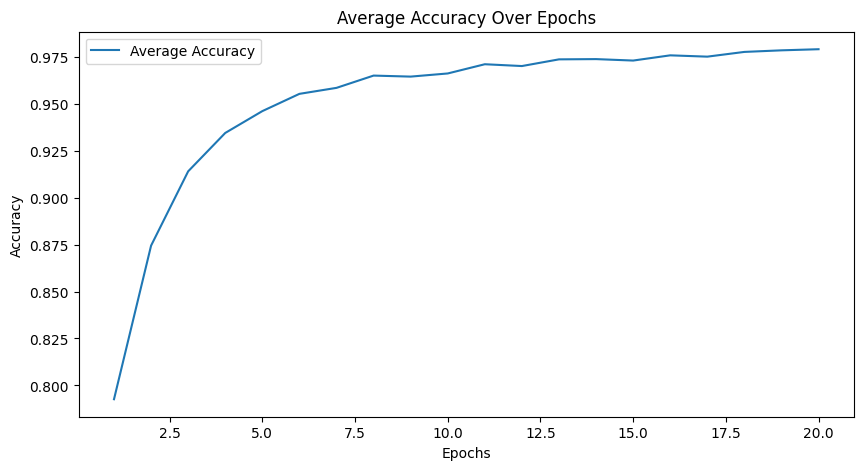

In [ ]:
# Calculate average accuracy for each epoch
avg_accuracies = [
    np.mean([accuracies[client][epoch] for client in range(len(clients))])
    for epoch in range(epochs)
]

# Plotting average accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), avg_accuracies, label="Average Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Average Accuracy Over Epochs")
plt.show()

# Save accuracies to a file
np.save("accuracies.npy", np.array(accuracies))

# Save losses to a file
np.save("losses.npy", np.array(losses))

In [ ]:
avg_accuracies

[0.7926416754722595,
 0.8744916617870331,
 0.9140749990940094,
 0.9345250010490418,
 0.9461583316326141,
 0.9553583264350891,
 0.9585499942302704,
 0.9650916695594788,
 0.964550006389618,
 0.9662249982357025,
 0.9711416661739349,
 0.9701749980449677,
 0.9737416625022888,
 0.9738750100135803,
 0.9731000006198883,
 0.9758833289146424,
 0.9751833319664002,
 0.9777083277702332,
 0.9785499989986419,
 0.9791416645050048]

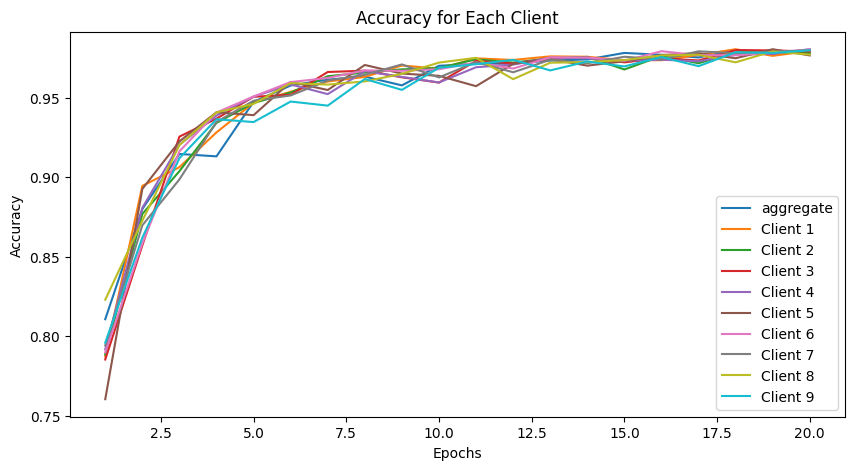

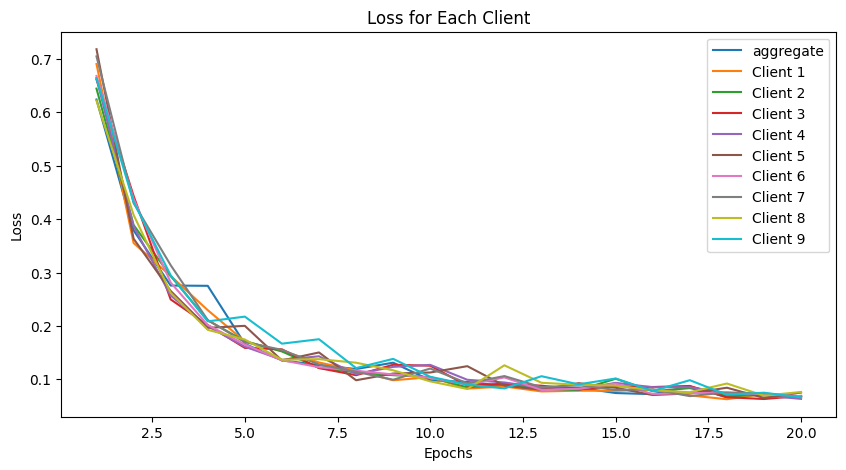

In [ ]:
import matplotlib.pyplot as plt

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(
        epochs_range,
        accuracies[i],
        label=f"Client {client}" if client != 0 else "aggregate",
    )
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

plt.figure(figsize=(10, 5))
for i, client in enumerate(clients):
    plt.plot(epochs_range, losses[i], label=f"Client {client}" if client != 0 else "aggregate")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss for Each Client")
plt.show()

In [ ]:
accuracies

[[0.8106666803359985,
  0.8799999952316284,
  0.9146666526794434,
  0.9131666421890259,
  0.9474999904632568,
  0.9577500224113464,
  0.9614166617393494,
  0.9633333086967468,
  0.9578333497047424,
  0.9701666831970215,
  0.9714166522026062,
  0.9715833067893982,
  0.9734166860580444,
  0.9741666913032532,
  0.9782500267028809,
  0.9770833253860474,
  0.9754166603088379,
  0.9800000190734863,
  0.9775000214576721,
  0.9798333048820496],
 [0.7871666550636292,
  0.8945833444595337,
  0.906333327293396,
  0.9282500147819519,
  0.9469166398048401,
  0.9538333415985107,
  0.9602500200271606,
  0.9631666541099548,
  0.9703333377838135,
  0.9683333039283752,
  0.9748333096504211,
  0.9738333225250244,
  0.9760833382606506,
  0.9758333563804626,
  0.9736666679382324,
  0.9736666679382324,
  0.9769999980926514,
  0.9805833101272583,
  0.9764166474342346,
  0.9794999957084656],
 [0.7884166836738586,
  0.8769166469573975,
  0.9038333296775818,
  0.934249997138977,
  0.9467499852180481,
  0.953333

In [ ]:
losses

[[0.6240193843841553,
  0.37908464670181274,
  0.27558690309524536,
  0.27509599924087524,
  0.16641609370708466,
  0.13552656769752502,
  0.12664158642292023,
  0.11926189064979553,
  0.13111674785614014,
  0.09822346270084381,
  0.09503418952226639,
  0.08768349140882492,
  0.08290096372365952,
  0.08438234776258469,
  0.07426363974809647,
  0.07216999679803848,
  0.08672262728214264,
  0.06618721783161163,
  0.07299784570932388,
  0.06691494584083557],
 [0.6904476881027222,
  0.35533663630485535,
  0.2935542166233063,
  0.22949771583080292,
  0.17096160352230072,
  0.15300752222537994,
  0.13149967789649963,
  0.11665809899568558,
  0.09815201908349991,
  0.10403987765312195,
  0.08255555480718613,
  0.08654487133026123,
  0.07727167010307312,
  0.07866542786359787,
  0.07844371348619461,
  0.08042190968990326,
  0.06982437521219254,
  0.0626894012093544,
  0.07243886590003967,
  0.06813608109951019],
 [0.6444790363311768,
  0.38900747895240784,
  0.29340922832489014,
  0.2104138582

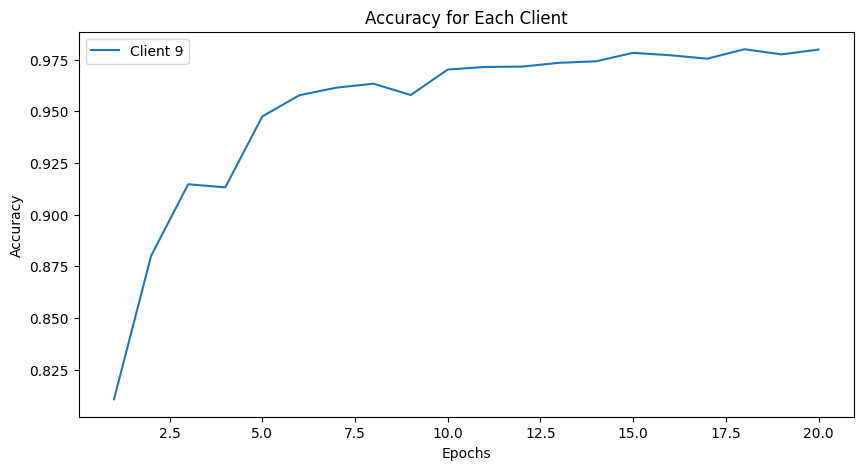

In [ ]:
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(10, 5))
# for i, client in enumerate(clients):
plt.plot(epochs_range, accuracies[0], label=f"Client {client}")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy for Each Client")
plt.show()

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

model = models[0]
# Assuming you have a trained model named 'model'
# and input data 'X_test' and corresponding labels 'y_test'

# Select a sample image from the test set
# Select a sample image from the test set
sample_image = X_test[1]  # Adjust the index as needed
sample_label = y_test[1]

# Preprocess the sample image
sample_image = sample_image[np.newaxis, ...]  # Add batch dimension

# Initialize the model
# model = model_init()

# Create a model that outputs the activations of the first dense layer
layer_name = "dense_40"  # Name of the first dense layer in your model
activation_model = Model(
    inputs=model.inputs, outputs=model.get_layer(layer_name).output
)

# Get the activations of the first dense layer
activations = activation_model.predict(sample_image)

# Plot the sample image and the activation map
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

ax1.imshow(sample_image[0], cmap="gray")  # Assuming grayscale image
ax1.set_title("Sample Image")
ax1.axis("off")

ax2.imshow(activations[0].reshape(2, 4), cmap="viridis", interpolation="nearest")
ax2.set_title("Activation Map")
ax2.set_xticks([])
ax2.set_yticks([])

plt.tight_layout()
plt.show()

NameError: name 'X_test' is not defined